In [8]:
from __future__ import print_function
import numpy as np
import scipy
import scipy.sparse
import scipy.sparse.linalg
import nibabel as nib
import dipy.align.imwarp as imwarp
import dipy.align.vector_fields as vfu
from dipy.align.imwarp import DiffeomorphicMap
from dipy.align import VerbosityLevels
from dipy.align.imaffine import MutualInformationMetric, AffineRegistration
from dipy.align.transforms import regtransforms
import dipy.correct.gradients as gr
import dipy.correct.splines as splines
from dipy.correct.splines import CubicSplineField
from dipy.correct.cc_splines import cc_splines_gradient
import dipy.viz.regtools as rt
from experiments.registration.regviz import overlay_slices
from inverse.dfinverse_3d import warp_points_3d, compute_jacobian_3d

In [10]:
def get_diag_affine(sp):
    A = np.eye(4)
    A[np.diag_indices(3)] = sp
    return A

In [35]:
data_dir = '/home/omar/data/topup_example/'
up_fname = data_dir + "b0_blipup.nii"
down_fname = data_dir + "b0_blipdown.nii"
up_unwarped_fname = data_dir+'b0_blipup_unwarped.nii'

In [13]:
radius = 4  # CC radius
nstages = 9  # Multi-resolution stages
fwhm = np.array([8, 6, 4, 3, 3, 2, 1, 0, 0], dtype=np.float64)
warp_res = np.array([20, 16, 14, 12, 10, 6, 4, 4, 4], dtype=np.float64)
subsampling = np.array([2, 2, 2, 2, 2, 1, 1, 1, 1], dtype=np.int32)
lambda1 = np.array([1e2, 1e2, 1e2, 1e2, 1e2, 1e2, 1e2, 1e2, 1e2])*2
lambda2 = np.array([1e2, 1e2, 1e2, 1e2, 1e2, 1e2, 1e2, 1e2, 1e1, 1])
max_iter = np.array([30, 1, 1, 1, 1, 1, 1, 1, 1], dtype=np.int32)

In [43]:
# Read and scale data
up_nib = nib.load(up_fname)
up_affine = up_nib.get_affine()
direction, spacings = imwarp.get_direction_and_spacings(up_affine, 3)
up_affine_inv = np.linalg.inv(up_affine)
up = up_nib.get_data().squeeze().astype(np.float64)
up /= up.mean()

down_nib = nib.load(down_fname)
down_affine = down_nib.get_affine()
down_affine_inv = np.linalg.inv(down_affine)
down = down_nib.get_data().squeeze().astype(np.float64)    
down /= down.mean()

unwarped_nib = nib.load(up_unwarped_fname)
unwarped_affine = unwarped_nib.get_affine()
unwarped_affine_inv = np.linalg.inv(unwarped_affine)
unwarped = unwarped_nib.get_data().squeeze().astype(np.float64)
unwarped -= unwarped.min()
unwarped /= unwarped.mean()

print('up range: %f, %f'%(up.min(), up.max()) )
print('dn range: %f, %f'%(down.min(), down.max()) )
print('uw range: %f, %f'%(unwarped.min(), unwarped.max()) )

up range: 0.000000, 51.552584
dn range: 0.000000, 71.248626
uw range: 0.000000, 10.827830


In [49]:
# Resample the input images
max_subsampling = subsampling.max()
in_shape = np.array(up.shape, dtype=np.int32)
# This makes no sense, it should be + (max_subsampling - regrid_shape%max_subsampling)%max_subsampling
regrid_shape = in_shape + max_subsampling
reg_sp = ((in_shape - 1) * spacings) / regrid_shape
regrid_affine = get_diag_affine(reg_sp)
regrid_affine_inv = np.linalg.inv(regrid_affine)
factors = reg_sp / spacings
resampled_up = np.array(gr.regrid(up, factors, regrid_shape)).astype(np.float64)
resampled_down = np.array(gr.regrid(down, factors, regrid_shape)).astype(np.float64)
resampled_unwarped = np.array(gr.regrid(unwarped, factors, regrid_shape)).astype(np.float64)

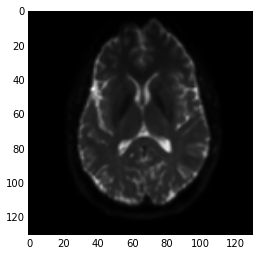

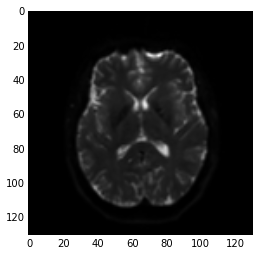

In [28]:
plt.figure()
plt.imshow(resampled_up[...,34].T[::-1,:], cmap=plt.cm.gray);
plt.figure()
plt.imshow(resampled_down[...,34].T[::-1,:], cmap=plt.cm.gray);

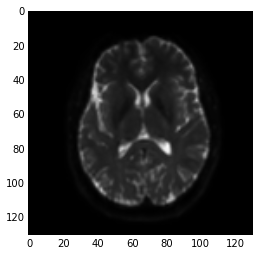

In [50]:
plt.imshow(resampled_unwarped[...,34].T[::-1,:], cmap=plt.cm.gray);

# Start field estimation

In [61]:
    # Choose static and moving
    static = resampled_unwarped
    moving = resampled_up
    if True:
        stage = 0
    #for stage in range(nstages):
        print("Stage: %d / %d"%(stage + 1, nstages))
        #subsample by 2, if required
        if subsampling[stage] > 1:
            sub_static = vfu.downsample_scalar_field_3d(static)
            sub_moving = vfu.downsample_scalar_field_3d(moving)
        else:
            sub_static = static
            sub_moving = moving

        resampled_sp = subsampling[stage] * reg_sp
        resampled_affine = get_diag_affine(resampled_sp)

        l1 = lambda1[stage]
        l2 = lambda2[stage]
        # get the spline resolution from millimeters to voxels
        kspacing = np.round(warp_res[stage]/resampled_sp).astype(np.int32)
        kspacing[kspacing<1] = 1
        sigma_mm = fwhm[stage] / (np.sqrt(8.0 * np.log(2)))
        sigma_vox = sigma_mm/resampled_sp
        print("kspacing:",kspacing)
        print("sigma_vox:",sigma_vox)

Stage: 1 / 9
kspacing: [6 6 6]
sigma_vox: [ 0.96766277  0.96766271  0.98594567]


In [64]:
        # Create, rescale or keep field as needed
        if field is None:
            # The field has not been created, this must be the first stage
            print ("Creating field")
            field = CubicSplineField(sub_static.shape, kspacing)
            b_coeff = np.zeros(field.num_coefficients())
            field.copy_coefficients(b_coeff)
            b = field.get_volume()
            b=b.astype(np.float64)

Creating field


In [65]:
        # smooth out images and compute spatial derivatives
        current_static = sp.ndimage.filters.gaussian_filter(sub_static, sigma_vox)
        current_moving = sp.ndimage.filters.gaussian_filter(sub_moving, sigma_vox)
        dcurrent_static = gr.der_y(current_static)
        dcurrent_moving = gr.der_y(current_moving)
        current_shape = np.array(current_static.shape, dtype=np.int32)
        current_sp = resampled_sp
        current_affine = get_diag_affine(current_sp)
        current_affine_inv = np.linalg.inv(current_affine)


In [67]:
        # Get spline kernel and its derivative. Evaluate full derivative
        kernel = field.spline3d.get_kernel_grid((0,0,0))
        dkernel = field.spline3d.get_kernel_grid((0,1,0))
        dfield = field.get_volume((0,1,0))
        dfield = np.array(dfield).astype(np.float64)


# Compute the gradient of CC w.r.t. spline coefficients

$$    \frac{\partial CC}{\partial c_{j}}(\mathbf{v}) = \left[\frac{2A(\mathbf{v})}{B(\mathbf{v})C(\mathbf{v})} \sum \limits_{\mathbf{w}\in \mathcal{W}_{\mathbf{v}}} G(\mathbf{w})
\frac{\partial F}{\partial c_{j}}(\mathbf{w})\right] -
    \left[\frac{2A(\mathbf{v})^{2}}{B(\mathbf{v})^{2}C(\mathbf{v})} \sum \limits_{\mathbf{w}\in \mathcal{W}_{\mathbf{v}}} F(\mathbf{w})
    \frac{\partial F}{\partial c_{j}}(\mathbf{w})\right]$$

In [87]:
        # Specify phase encode direction. Create buffer to hold gradient
        pedir_factor = 1.0
        kcoef_grad = np.zeros_like(field.coef)
        energy = cc_splines_gradient(current_static, current_moving,
                        dcurrent_static, dcurrent_moving,
                        pedir_factor,
                        None, None,
                        kernel, dkernel,
                        dfield, field.kspacing,
                        field.grid_shape, radius,
                        kcoef_grad)

In [97]:
        # Visualize the gradient descent direction
        field.copy_coefficients(kcoef_grad)  # Set spline coefficients from the computed gradient
        orfield = field.get_volume((0,0,0))  # Evaluate the field along he full grid

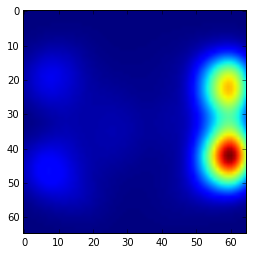

In [95]:
plt.imshow(orfield[...,17]);

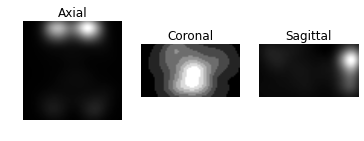

In [92]:
rt.plot_slices(orfield);